In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10840923611277821636, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4341850951598377723
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11951774106
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 16481502549042735413
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 12057427968
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
     li

In [3]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.14.0
dim_ordering: tf


Using TensorFlow backend.


In [4]:
import os
import numpy as np
#np.random.seed(777)
import pandas as pd
import pathlib
import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import MobileNet
from keras.applications import DenseNet121
from keras.layers.core import Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.initializers import he_normal, glorot_normal
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [5]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(len(df_train_for_keras))

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(len(df_val_for_keras)+len(df_train_for_keras)+len(df_test_for_keras))

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

38070
                                           relative_path label
38070   Pepper,_bell___Bacterial_spot/JR_B.Spot 3293.JPG    18
38071        Squash___Powdery_mildew/UMD_Powd.M 0707.JPG    25
38072              Apple___Apple_scab/FREC_Scab 3120.JPG     0
38073               Grape___Black_rot/FAM_B.Rot 3107.JPG    11
38074  Tomato___Tomato_Yellow_Leaf_Curl_Virus/UF.GRC_...    35
54272


In [122]:
df_test_for_keras

,relative_path,label
0,Tomato___Tomato_Yellow_Leaf_Curl_Virus/YLCV_NR...,35
1,Corn_(maize)___healthy/R.S_HL 7921 copy 2.jpg,10
2,Potato___Late_blight/RS_LB 3303.JPG,21
3,Tomato___Leaf_Mold/Crnl_L.Mold 8757.JPG,31
4,Tomato___Bacterial_spot/UF.GRC_BS_Lab Leaf 898...,28
5,Corn_(maize)___Common_rust_/RS_Rust 2468.JPG,8
6,Soybean___healthy/RS_HL 7481.JPG,24
7,Peach___Bacterial_spot/Rutg._Bact.S 1411.JPG,16
8,Peach___Bacterial_spot/Rut._Bact.S 0752.JPG,16
9,Apple___Black_rot/JR_FrgE.S 3031.JPG,1


In [124]:
test_generator = test_datagen.flow_from_dataframe(df_test_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                shuffle=False,
                                                drop_duplicates=False)
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 10951 validated image filenames belonging to 38 classes.
Found 38070 validated image filenames belonging to 38 classes.
Found 5251 validated image filenames belonging to 38 classes.


In [8]:
print(train_generator.class_indices)

{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '4': 32, '5': 33, '6': 34, '7': 35, '8': 36, '9': 37}


In [67]:
val_generator.classes[0]

10

In [11]:
output_classes = 38
batch_size = 16
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 20

nb_train_samples = 103104
nb_validation_samples = 12288
nb_test_samples = 697

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [13]:
def build_keras_model():    
    base_model = MobileNet(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

    x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

    model = Model(inputs=base_model.input,outputs=prediction)
    return model

In [14]:
model_check=build_keras_model()
model_check.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_____________________

In [15]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=True)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
train_model = build_keras_model()
train_model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:

callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = train_model.fit_generator(
  train_generator,
  steps_per_epoch = 849,
  epochs = epochs,
  validation_data = val_generator,
  validation_steps = 170,
  callbacks = callbacks)

# with open('models/vgg19_history.txt','w') as f:
#     f.write(str(history.history))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
849/849 [==============================] - 268s 316ms/step - loss: 1.4251 - acc: 0.6767 - val_loss: 0.4941 - val_acc: 0.9232
Epoch 2/20
849/849 [==============================] - 302s 355ms/step - loss: 0.6072 - acc: 0.8816 - val_loss: 0.3535 - val_acc: 0.9568
Epoch 3/20
849/849 [==============================] - 237s 279ms/step - loss: 0.4745 - acc: 0.9219 - val_loss: 0.3145 - val_acc: 0.9640
Epoch 4/20
849/849 [==============================] - 147s 174ms/step - loss: 0.4050 - acc: 0.9421 - val_loss: 0.3106 - val_acc: 0.9682
Epoch 5/20
849/849 [==============================] - 149s 175ms/step - loss: 0.3699 - acc: 0.9494 - val_loss: 0.2733 - val_acc: 0.9776
Epoch 6/20
849/849 [==============================] - 146s 172ms/step - loss: 0.3472 - acc: 0.9583 - val_loss: 0.2895 - val_acc: 0.9767
Epoch 7/20
849/849 [==============================] - 147s 173ms/step - loss: 0.3287 - acc

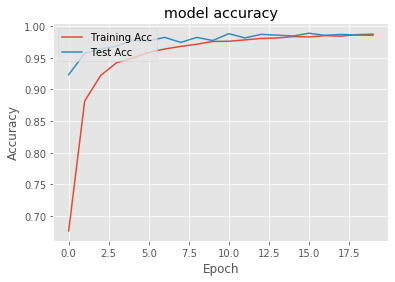

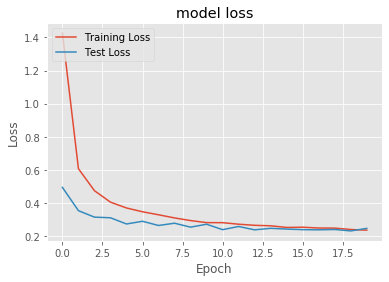

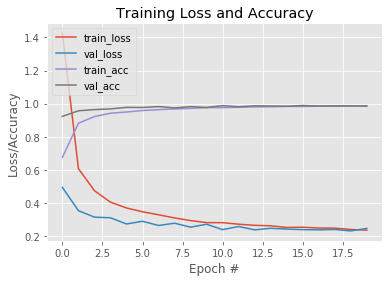

In [18]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [125]:
score = train_model.evaluate_generator(test_generator, steps=100,verbose=1 )

# Print out final values of all metrics
key2name = {'acc':'Accuracy', 'loss':'Loss', 
    'val_acc':'Validation Accuracy', 'val_loss':'Validation Loss'}

results = []
for i,key in enumerate(train_model.metrics_names):
    results.append('%s = %.2f' % (key2name[key], score[i]))
print(", ".join(results))

100/100 [==============================] - 29s 289ms/step
Loss = 0.24, Accuracy = 0.99


In [ ]:
train_model.summary()

In [126]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
#indexlabel = dict((value, key) for key, value in label.items())
indexlabel = dict(map(reversed, label.items()))
#print(Inverted_classes)

predicts = train_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class == truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

685/684 [==============================] - 183s 267ms/step
No of errors = 547/10951


In [127]:
truth

[29,
 2,
 14,
 25,
 21,
 36,
 17,
 8,
 8,
 1,
 29,
 8,
 9,
 17,
 23,
 9,
 3,
 26,
 29,
 2,
 2,
 17,
 29,
 30,
 26,
 18,
 28,
 34,
 37,
 17,
 18,
 23,
 27,
 24,
 7,
 7,
 7,
 29,
 26,
 29,
 7,
 31,
 17,
 29,
 23,
 33,
 21,
 22,
 17,
 11,
 28,
 23,
 17,
 17,
 37,
 19,
 4,
 23,
 22,
 17,
 17,
 21,
 11,
 13,
 17,
 8,
 34,
 17,
 7,
 7,
 31,
 17,
 29,
 5,
 6,
 30,
 4,
 17,
 29,
 26,
 2,
 21,
 11,
 36,
 18,
 29,
 25,
 8,
 8,
 18,
 33,
 33,
 5,
 27,
 26,
 18,
 7,
 31,
 7,
 24,
 17,
 23,
 4,
 19,
 29,
 29,
 36,
 4,
 3,
 2,
 27,
 25,
 24,
 1,
 26,
 27,
 17,
 18,
 23,
 20,
 0,
 25,
 29,
 36,
 29,
 11,
 18,
 29,
 4,
 3,
 29,
 7,
 35,
 23,
 29,
 5,
 23,
 29,
 29,
 28,
 24,
 11,
 7,
 33,
 17,
 36,
 5,
 29,
 18,
 17,
 24,
 17,
 32,
 29,
 29,
 18,
 26,
 8,
 36,
 31,
 24,
 22,
 18,
 5,
 32,
 9,
 2,
 5,
 7,
 18,
 29,
 29,
 36,
 8,
 4,
 2,
 33,
 7,
 20,
 17,
 10,
 7,
 17,
 29,
 8,
 36,
 7,
 32,
 20,
 2,
 6,
 36,
 2,
 27,
 0,
 24,
 6,
 11,
 31,
 4,
 26,
 22,
 17,
 23,
 21,
 21,
 30,
 36,
 13,
 24,
 24,
 7,

In [128]:
predict_class

array([29, 25, 29, ...,  7, 24, 29])

In [ ]:
print(Y_pred)

In [93]:
pwd

'/media/storage1/njera/final'

In [87]:
truth

[10,
 18,
 0,
 3,
 29,
 11,
 21,
 14,
 29,
 27,
 16,
 24,
 20,
 7,
 8,
 17,
 13,
 21,
 7,
 7,
 31,
 8,
 29,
 8,
 31,
 7,
 17,
 29,
 29,
 17,
 24,
 10,
 17,
 32,
 31,
 7,
 32,
 14,
 29,
 29,
 35,
 29,
 21,
 25,
 17,
 28,
 14,
 29,
 29,
 33,
 21,
 32,
 17,
 17,
 29,
 0,
 2,
 29,
 23,
 32,
 37,
 17,
 7,
 27,
 21,
 17,
 24,
 29,
 32,
 18,
 18,
 7,
 17,
 11,
 26,
 24,
 21,
 2,
 17,
 8,
 8,
 17,
 8,
 23,
 29,
 1,
 7,
 28,
 18,
 14,
 17,
 16,
 31,
 36,
 3,
 10,
 29,
 7,
 2,
 21,
 22,
 1,
 1,
 7,
 28,
 33,
 17,
 7,
 17,
 6,
 0,
 18,
 30,
 26,
 7,
 22,
 17,
 29,
 11,
 18,
 4,
 23,
 14,
 24,
 29,
 21,
 20,
 29,
 35,
 2,
 7,
 17,
 7,
 35,
 17,
 0,
 21,
 34,
 26,
 36,
 7,
 31,
 11,
 21,
 5,
 26,
 18,
 17,
 18,
 0,
 11,
 18,
 7,
 17,
 29,
 14,
 29,
 1,
 18,
 31,
 13,
 18,
 33,
 24,
 32,
 17,
 17,
 8,
 7,
 26,
 8,
 32,
 19,
 14,
 29,
 23,
 4,
 32,
 29,
 24,
 35,
 7,
 8,
 29,
 21,
 8,
 22,
 29,
 17,
 32,
 37,
 12,
 31,
 17,
 23,
 8,
 26,
 4,
 19,
 7,
 7,
 29,
 17,
 5,
 8,
 11,
 18,
 7,
 5,
 11,
 28,


Confusion Matrix
[[ 2  3  3 ...  1  2  2]
 [ 2  2  4 ...  1  1  3]
 [ 0  4  2 ...  1  4  6]
 ...
 [ 0  1  2 ...  1  2  3]
 [ 2  2  6 ...  5 10  4]
 [ 1  2  1 ...  0  8  0]]


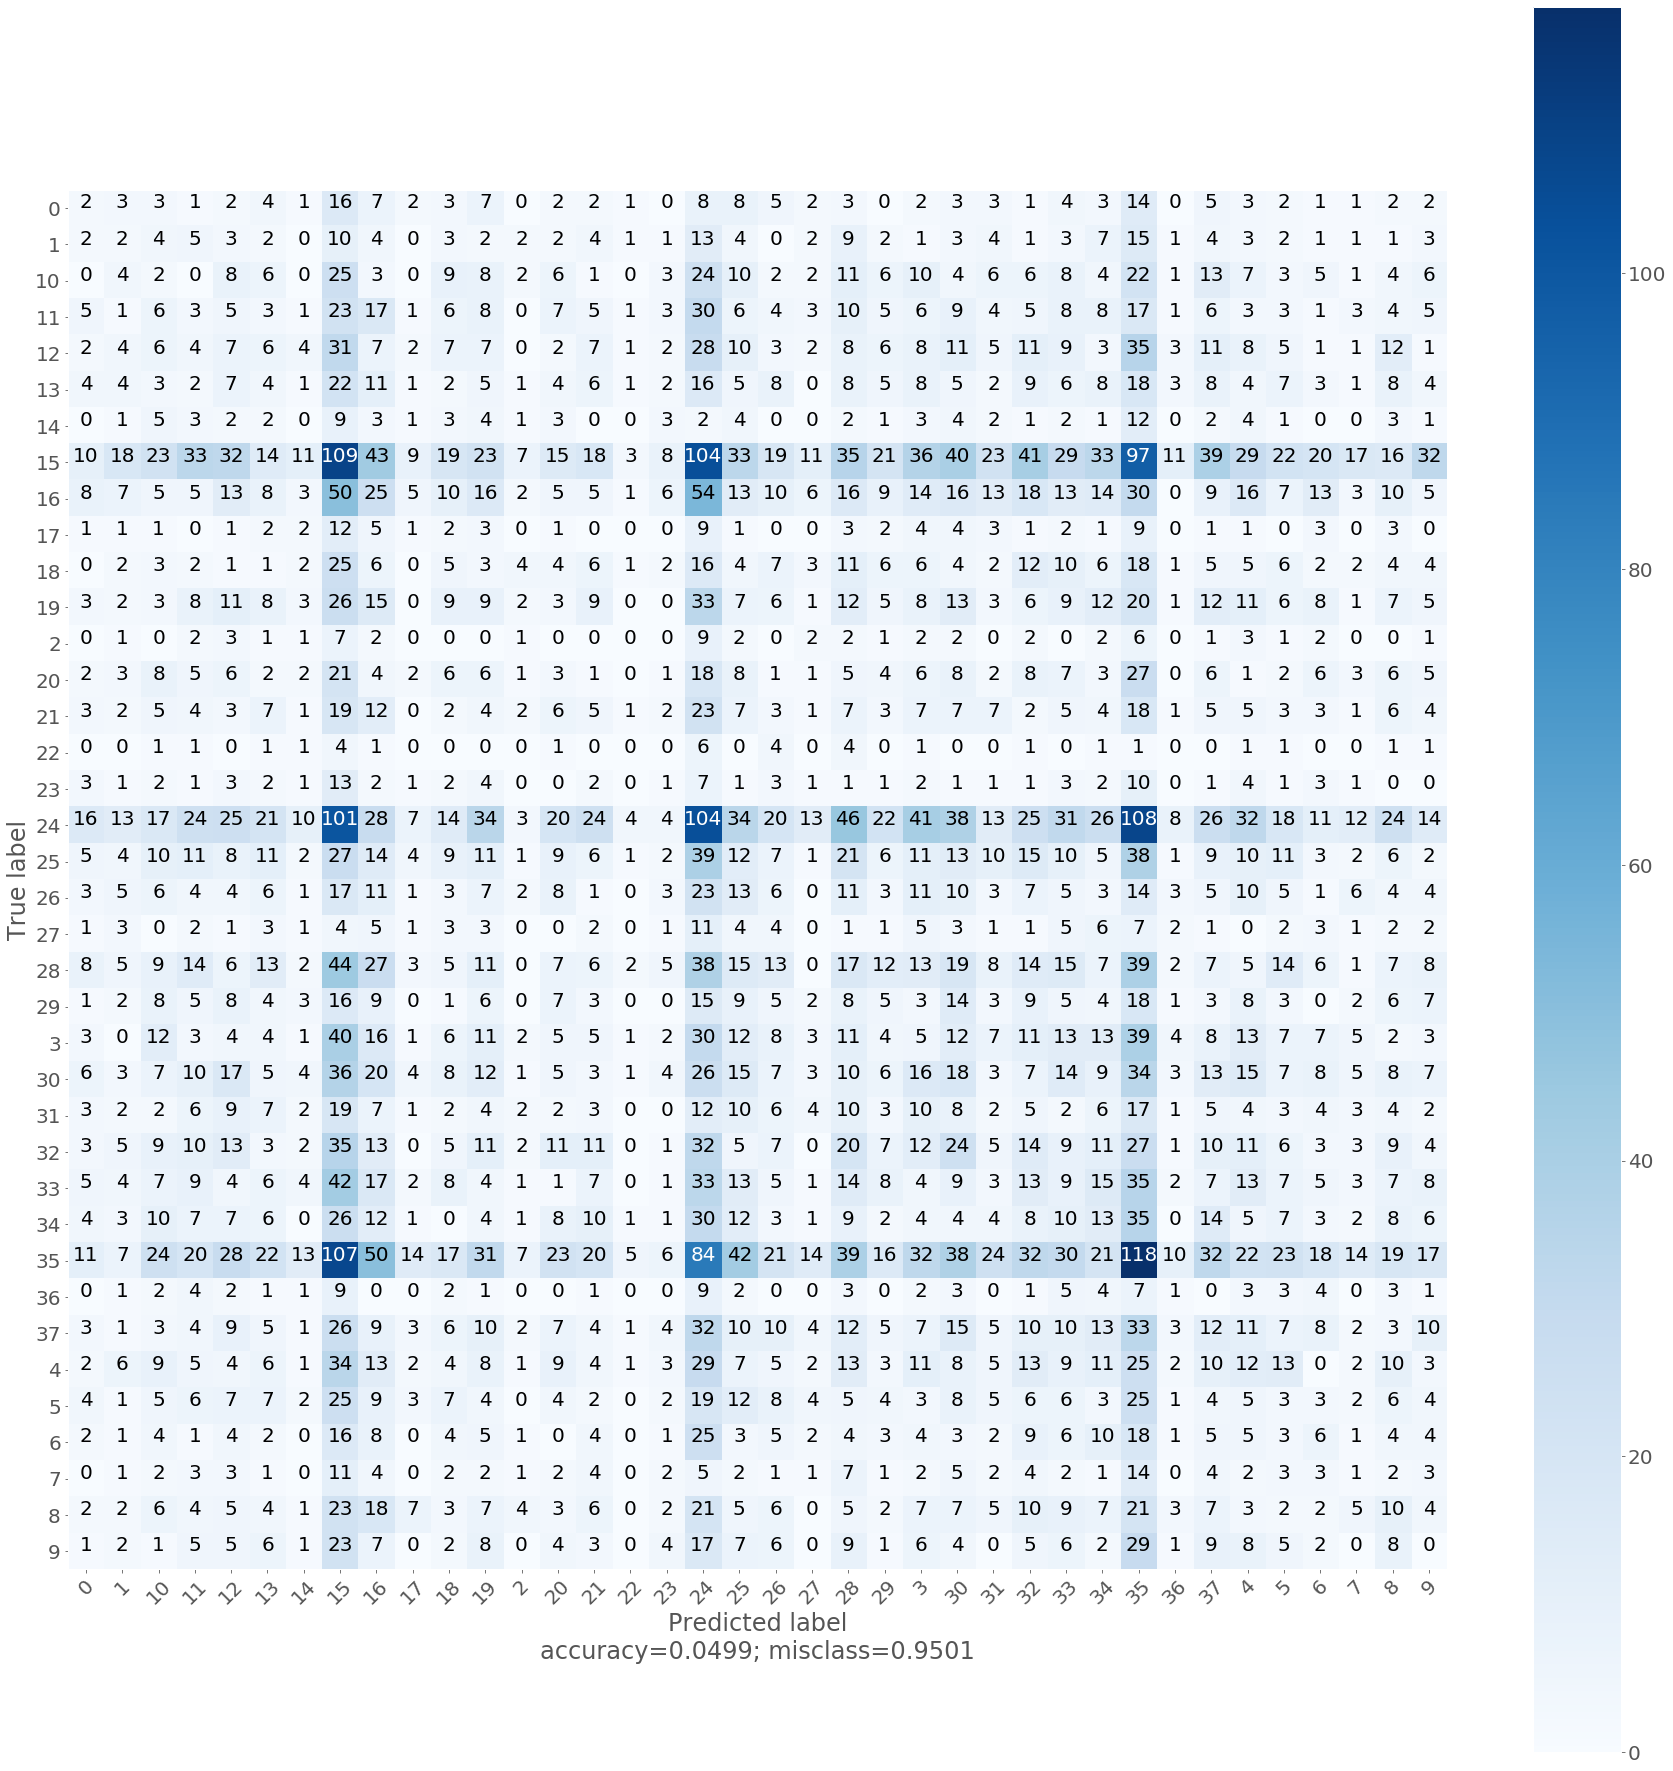

In [129]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(25,25))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [132]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 2  3  3 ...  1  2  2]
 [ 2  2  4 ...  1  1  3]
 [ 0  4  2 ...  1  4  6]
 ...
 [ 0  1  2 ...  1  2  3]
 [ 2  2  6 ...  5 10  4]
 [ 1  2  1 ...  0  8  0]]
              precision    recall  f1-score   support

           0       0.02      0.02      0.02       128
           1       0.02      0.02      0.02       127
          10       0.01      0.01      0.01       232
          11       0.01      0.01      0.01       236
          12       0.03      0.03      0.03       280
          13       0.02      0.02      0.02       216
          14       0.00      0.00      0.00        85
          15       0.10      0.10      0.10      1103
          16       0.05      0.05      0.05       463
          17       0.01      0.01      0.01        79
          18       0.03      0.02      0.03       201
          19       0.03      0.03      0.03       297
           2       0.02      0.02      0.02        56
          20       0.02      0.01      0.02       200
          21       0.03      0.03

In [133]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  0.03652634462606155
Sensitivity :  50.0
Specificity :  40.0
